In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install langchain sentence-transformers faiss-cpu pypdf transformers torch langchain-community  #instalujemy potrzebne biblioteki

In [ ]:
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.llms import HuggingFacePipeline
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, AutoModelForSeq2SeqLM
from langchain.chains import RetrievalQA

from google.colab import drive
drive.mount('/content/drive')

# interakcja z systemem. Między innymi zarządzanie plikami, tworzenie folderów.
import os

# MOŻESZ IMPORTOWAĆ INNE BIBLIOTEKI, ALE PAMIĘTAJ O ICH INSTALACJI W WIERSZU POWYŻEJ !!!
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
from langchain.prompts import PromptTemplate

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Asystent AI - PDF RAG
Po dwóch udanych misjach – rozwikłaniu tajemnicy przeżycia na Titanicu i odczytaniu ręcznych notatek o pokojach – myślałeś, że zasłużysz na odpoczynek. Jednak telefon od tajemniczego zleceniodawcy rozbrzmiał ponownie, tym razem z jeszcze pilniejszą sprawą.

"Wasze poprzednie modele były kluczowe," – rozpoczął głos w słuchawce – "ale to dopiero wstęp do prawdziwego wyzwania. Nasi agenci przechwycili poufny szpont dokumentów. To nie są zwykłe papiery; to zestaw od 3 do 5 artykułów naukowych w formacie PDF, które zawierają fragmenty przełomowych badań. Informacje są niekompletne, celowo pomieszane i zaszyfrowane."

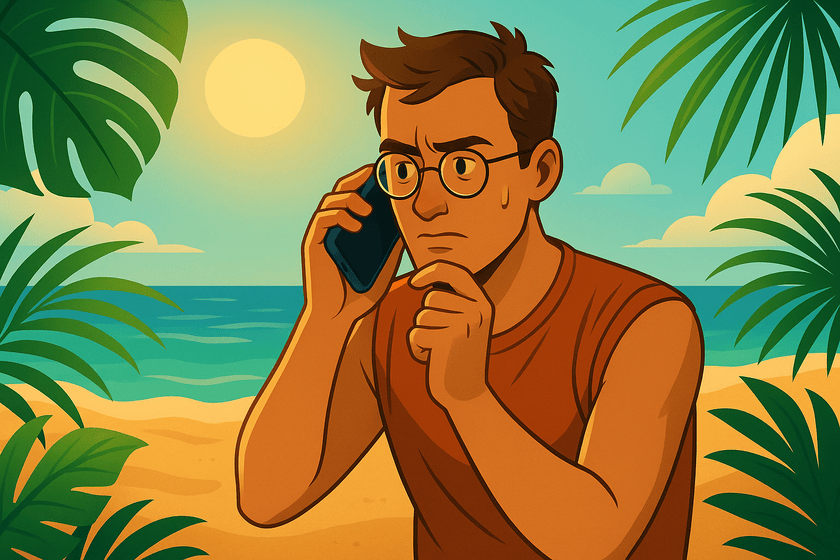

(*AI-generated image*)

### Zadanie
Twoim celem będzie stworzenie asystenta RAG - Retrival Augmented Generation na podstawie kilku plików PDF z artykułami naukowymi na wybrany przez siebie temat (3-5 artykułów).
### Poniżej znajdziesz pytania, które mogą być pomocne w zadaniu:
- Czy model poprawnie odpowiada na pytania ?
- Jakie są etapy przetwarzania dokumentu tekstowego ?
- Jaki wynik jest "dobry" ?
- Co robi mój asystent AI ? Jak on działa ? Jak tworzona jest odpowiedź ?
- Czy model poprawnie wybiera fragment dokumentu ? Czy poprawnie korzysta z bazy ?
- Jaką rolę w naszym systemie pełni baza wektorowa ?

### Wymagania
- Przygotuj artykuły naukowe i umieść je w folderze na dysku
- Stwórz wektorową bazę danych (można użyć innego systemu niż FAISS)
- Zapełnij bazę embeddingami z modelu wybranego przez Ciebie z [Sentence Similarity Models](https://huggingface.co/models?pipeline_tag=sentence-similarity&sort=trending) z HuggingFace Hub - innego niż podany w notebooku wzorcowym
- Zainicjuj wybrany model QA z dostępnych [Question Answering Models](https://huggingface.co/models?pipeline_tag=question-answering&sort=trending) z HuggingFace Hub - również innego niż w notebooku wzorcowym
- Stwórz chaina odpowiadania na pytania i dodaj mechanizm pętli - tak, żeby można było przeprowadzać swobodną rozmowę z asystentem

**Dodatkowe wymagania**
- Mechanizm pamięci konwersacji - tak, żeby model pamiętał poprzednią część konwersacji
- Mechanizm braku halucynacji (bez cyberpsychozy) - jeśli model nie znajdzie odpowiedzi w bazie, informuje o tym
- Cytowanie dokumentu, z którego model pobrał informacje

Niezmiennie, zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza Markdown.






U mnie artykuły znajdują się w folderze artykuly2. Jak będziesz odpalał wpisz w jego miejsce twój folder.

In [ ]:
# Ładowanie wybranych plików PDF z folderu


# Replace '/content/drive/My Drive/artykuly/' with the actual path to your folder containing PDF files
folder_path = "/content/drive/My Drive/artykuly2/"

# Specify the list of filenames you want to process
selected_filenames = ["model.pdf", "music.pdf", "games.pdf" , "humor_art.pdf"] # Zmień nazwy plików na te, które chcesz przetworzyć

all_pages = []
for filename in selected_filenames:
    file_path = os.path.join(folder_path, filename)
    if os.path.exists(file_path): # Check if the file exists
        loader = PyPDFLoader(file_path)
        pages = loader.load()
        all_pages.extend(pages)
    else:
        print(f"Warning: File '{filename}' not found in the specified folder.")


# Podział tekstu na fragmenty
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=300,
    chunk_overlap=100,
    length_function=len,
    separators=["\n\n", "\n", " ", ""]
)
docs = text_splitter.split_documents(all_pages)

for idx,doc in enumerate(docs):
  print(f"[{idx}].{doc}\n\n")


[0].page_content='On Identifying Why and When Foundation Models Perform Well on Time-Series
Forecasting Using Automated Explanations and Rating
Michael ”Xander” Widener, Kausik Lakkaraju, John Aydin, Biplav Srivastava
Department of Computer Science and Engineering, University of South Carolina, Columbia, SC, USA' metadata={'producer': 'pikepdf 8.15.1', 'creator': 'arXiv GenPDF (tex2pdf:)', 'creationdate': '', 'author': 'Michael Widener; Kausik Lakkaraju; John Aydin; Biplav Srivastava', 'doi': 'https://doi.org/10.48550/arXiv.2508.20437', 'license': 'http://creativecommons.org/licenses/by-nc-nd/4.0/', 'ptex.fullbanner': 'This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) kpathsea version 6.3.5', 'templateversion': '2026.1', 'title': 'On Identifying Why and When Foundation Models Perform Well on Time-Series Forecasting Using Automated Explanations and Rating', 'trapped': '/False', 'arxivid': 'https://arxiv.org/abs/2508.20437v1', 'source': '/content/drive/My Drive/artykuly2/mo

Tworzenie wektorowej bazy danych. Może być coś innego niż FAISS.

Szukam innego modelu embeddings

In [ ]:
#embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
#embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-roberta-large-v1")
embeddings = HuggingFaceEmbeddings(model_name="AI-Growth-Lab/PatentSBERTa")

/tmp/ipython-input-689547882.py:3: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="AI-Growth-Lab/PatentSBERTa")
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  w

In [ ]:

# to się liczy 8 minut
db = FAISS.from_documents(docs, embeddings)

db.save_local("faiss_index_hf")

Wyszukiwanie informacji w artykułach. Do zmiennej query przypisz to co chesz znaleźć.


In [ ]:
# Wczytanie bazy danych
db = FAISS.load_local("faiss_index_hf", embeddings, allow_dangerous_deserialization=True)

# Wyszukiwanie podobnych fragmentów
query = "How to detect missinformation"
similar_docs = db.similarity_search(query, k=3)  # top 3 wyniki

for doc in similar_docs:
    print(doc.page_content[:300] + "...\n---")

automated, and intent-aware detection is urgently needed to protect digital trust [28].
2.1 Multimodal Misinformation Detection
Given the significant social impact of misinformation and the growing prevalence of multimodal forms of misinformation,...
---
evidence to detect out-of-context mis-and disinformation. In Proceedings of the 2023 Conference on Empirical
Methods in Natural Language Processing, pages 4268–4280, 2023.
[23] Stefanos-Iordanis Papadopoulos, Christos Koutlis, Symeon Papadopoulos, and Panagiotis C. Petrantonakis....
---
robust benchmark for multimodal misinformation detection.
2.3 Synthetic Image Detection
Beyond multimodal misinformation detection, there has been growing interest in the detection of synthetic images....
---


Twozrenie lokalnego modelu LLm do odpowiadania na pytania na podstawie artykułów.

In [ ]:
#to działa dobrze

#  Wybieramy odpowiedni model (instrukcyjnie dostrojony)
model_name = "stabilityai/stablelm-2-zephyr-1_6b"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype="auto"
)

# Pipeline dla generacji tekstu
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=30,
    temperature=0.9,
    top_p=0.6,
    repetition_penalty=1.1
)

llm = HuggingFacePipeline(pipeline=pipe)

# Prompt z kontekstem
template = """
You are an expert AI assistant .
Use the following context to answer the question.
If the context does not match the question, answer: I don't know the answer to this question.

Context:
{context}

Question:
{question}

Answer clearly and concisely:
"""
prompt = PromptTemplate(
    template=template,
    input_variables=["context", "question"]
)

# RetrievalQA z kontekstem
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=db.as_retriever(),
    chain_type_kwargs={"prompt": prompt}
)


Device set to use cpu


Wpisz po query swoje pytanie

In [ ]:
result = qa_chain.invoke({"query": "What meanss S-HArM"})
print(f"AI Assistant: {result['result']}")

AI Assistant: 
You are an expert AI assistant .
Use the following context to answer the question.
If the context does not match the question, answer: I don't know the answer to this question.

Context:
5 Conclusion
In this work, we introduced S-HArM, a novel dataset for intent-aware classification of synthetic multimodal content.
Unlike previous efforts that focus on detecting synthetic or decontextualized images, S-HArM targets a more nuanced

content. However, existing efforts largely overlook the intent behind AI-generated images. To fill
this gap, we introduce S-HArM, a multimodal dataset for intent-aware classification, comprising
9,576 “in the wild” image–text pairs from Twitter/X and Reddit, labeled as Humor/Satire, Art, or

“evidence” to support it. However, without the textual modality, the intent behind the generation of this image would be
ambiguous.
To address this gap, we introduce S-HArM (Synthetic–Humor, Art, Misinformation), a multimodal dataset for intent-

humor/satir

Pętla do wprowadzania pytań z inputa. Trzeba wpisać exit żeby zakończyć  jej działanie

In [ ]:
text = " "
while True:
  text = input("Wpisz pytanie. Jeśli chcesz zakończyć wpisz 'exit' ")
  if text == "exit":
    break
  result = qa_chain.invoke({"query": text})
  print(f"AI Assistant: {result['result']}")

Wpisz pytanie. Jeśli chcesz zakończyć wpisz 'exit' exit


Wersja z pamięcią. Strasznie wolno działa

In [28]:

model_name = "stabilityai/stablelm-2-zephyr-1_6b"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype="auto"
)

#Pipeline do generacji tekstu
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=60,
    temperature=0.8,
    top_p=0.9,
    repetition_penalty=1.1
)

llm = HuggingFacePipeline(pipeline=pipe)

#Definiuje prompt z kontekstem
template = """
Use the following retrieved context and the chat history to answer.

Chat history:
{chat_history}

Context:
{context}

Question:
{question}

Answer clearly and concisely:
"""
prompt = PromptTemplate(
    template=template,
    input_variables=["chat_history", "context", "question"]
)

#  Pamięć rozmowy
memory = ConversationBufferMemory(
    memory_key="chat_history",
    return_messages=True
)

# Conversational RAG (z pamięcią)
qa_chain = ConversationalRetrievalChain.from_llm(
    llm=llm,
    retriever=db.as_retriever(),
    memory=memory,
    combine_docs_chain_kwargs={"prompt": prompt}
)

Device set to use cpu


Wpisz swoje pytanie po question.

In [29]:
print("aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa")
#  Pierwsze pytanie
result1 = qa_chain.invoke({"question": "What meanss S-HArM"})
print("AI:", result1["answer"])

print("bbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbb")

#Kolejne pytanie bazujące na pamięci
result2 = qa_chain.invoke({"question": "Can you summarize it in one sentence?"})
print("AI:", result2["answer"])



aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
AI: 
Use the following retrieved context and the chat history to answer.

Chat history:


Context:
5 Conclusion
In this work, we introduced S-HArM, a novel dataset for intent-aware classification of synthetic multimodal content.
Unlike previous efforts that focus on detecting synthetic or decontextualized images, S-HArM targets a more nuanced

content. However, existing efforts largely overlook the intent behind AI-generated images. To fill
this gap, we introduce S-HArM, a multimodal dataset for intent-aware classification, comprising
9,576 “in the wild” image–text pairs from Twitter/X and Reddit, labeled as Humor/Satire, Art, or

“evidence” to support it. However, without the textual modality, the intent behind the generation of this image would be
ambiguous.
To address this gap, we introduce S-HArM (Synthetic–Humor, Art, Misinformation), a multimodal dataset for intent-

humor/satire, art, or misinformation, making them unsuitable for our

KeyboardInterrupt: 